In [2]:
# autoreload to reload modules when they change
%load_ext autoreload
%autoreload 2

import rollout
from torch import optim
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn

from tqdm import trange
import networkx as nx
import math
import seaborn as sns

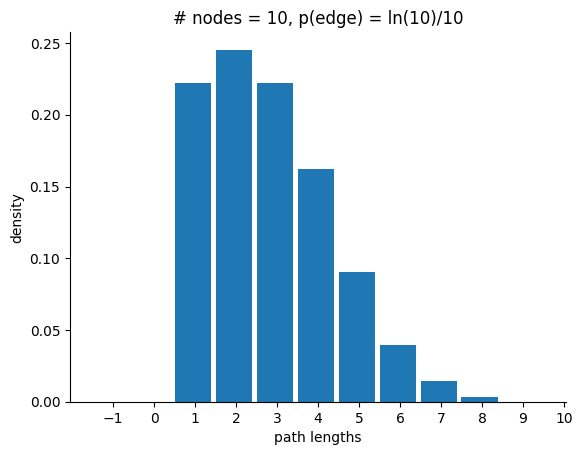

In [3]:
# check distributon of random graph path lengths
n_iters = 1000
path_lengths = []
n_edges = []
n_nodes = 10
p = math.log(n_nodes)/n_nodes

for _iter in range(n_iters):
    g = nx.connected_watts_strogatz_graph(n_nodes, k=2 , p=p)
    n_edges.append(len(g.edges))
    for n1 in g.nodes:
        for n2 in g.nodes:
            if n1 != n2:
                try:
                    path_lengths.append(nx.shortest_path_length(g, n1, n2))
                except nx.NetworkXNoPath:
                    path_lengths.append(-1)
plt.hist(path_lengths, bins=range(-1, n_nodes+1), density=True, align='left', width=0.9)
plt.xticks(range(-1, n_nodes+1))
plt.xlabel("path lengths")
plt.ylabel("density")
plt.title("# nodes = {n_nodes}, p(edge) = ln({n_nodes})/{n_nodes}".format(n_nodes=n_nodes))
sns.despine()

plt.show()

In [4]:
def edge_to_str(edge):
    return chr(edge[0] + ord('a')) + chr(edge[1] + ord('a')) + "."

def edge_context(edges):
    return "".join([edge_to_str(edge) for edge in edges])

def query(n1, n2):
    return chr(n1 + ord('a')) + chr(n2 + ord('a')) + "?"

def max_question_length(n_nodes):
    return len(generate_question(nx.connected_watts_strogatz_graph(n_nodes, k=2, p=0))[0])

def generate_question(G, n1=None, n2=None):
    assert n1 is None or n1 in G.nodes, "n1 is not a node in the graph"
    assert n2 is None or n2 in G.nodes, "n2 is not a node in the graph"
    
    if n1 is None and n2 is None:
        n1, n2 = np.random.choice(list(G.nodes), replace=False, size=2)
    else:
        assert n1 != n2, "n1 and n2 are the same node"
        if n1 is None:
            n1 = np.random.choice(list(G.nodes))
        if n2 is None:
            n2 = np.random.choice(list(G.nodes))
    try: 
        answer = nx.shortest_path_length(G, n1, n2)
    except nx.NetworkXNoPath:
        answer = -1
    edges = list(G.edges)
    return edge_context(edges) + query(n1, n2), answer

def create_token_map(n_nodes):
    token_map = {}
    for i in range(n_nodes):
        token_map[i] = i
    for i in range(n_nodes):
        token_map[chr(i + ord('a'))] = i + n_nodes 

    token_map["."] = 2*n_nodes
    token_map["-"] = 2*n_nodes + 1
    token_map["?"] = 2*n_nodes + 2
    token_map["pad"] = 2*n_nodes + 3
    token_map[-1] = 2*n_nodes + 4
    return token_map

def tokenize(input_str, token_map):
    return torch.tensor([token_map[c] for c in input_str])

from torch.utils.data import Dataset, DataLoader
from itertools import permutations, combinations
class graphDataset(Dataset):
    def __init__(self, n_nodes, n_graphs, train_test_split=0.75, k=2, p=0.4):
        self.n_nodes = n_nodes
        self.p = p        
        self.k = k
        self.train_test_split = train_test_split
        self.token_map = create_token_map(n_nodes)
        self.inverse_map = {v:k for k, v in self.token_map.items()}
        self.n_tokens = len(self.token_map)
        self.max_length = max_question_length(n_nodes)
        
        self.X = torch.zeros(n_graphs, self.max_length, dtype=torch.long)
        self.y = torch.zeros(n_graphs, dtype=torch.long)

        for i in range(n_graphs):
            g = self._generate_graph()
            self.X[i], self.y[i] = self._generate_question_(g)

        self.n_samples = n_graphs
        self.n_train = int(self.n_samples*self.train_test_split)
        self.train_idx = torch.arange(self.n_train)

        self.test_idx = torch.arange(self.n_train, self.n_samples)
        self.n_test = len(self.test_idx)

    def _generate_question_(self, G, n1=None, n2=None):
            q, a = generate_question(G, n1, n2)
            q, a = tokenize(q, self.token_map), torch.tensor(self.token_map[a])
            return (q, a)
    
    def _generate_graph(self):
        g = nx.connected_watts_strogatz_graph(self.n_nodes, k=self.k, p=self.p)
        g.edges = np.random.permutation([np.random.permutation(edge) for edge in g.edges])    
        return g
    
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx):
        return 

    def generate_batch_new(self, batch_size, type='train'):
        """
        Generates a batch of data for training or testing.
        Args:
            batch_size (int): Number of samples in the batch.
            type (str, optional): Type of data to generate ('train' or 'test'). Defaults to 'train'.
        Returns:
            tuple: A tuple containing the input sequences (X) and the output sequences (y).
        """
        assert type in ['train', 'test'], "type must be either 'train' or 'test'"
        
        question_pairs = np.random.permutation(list(permutations(range(5), 2)))
        n_pairs = len(question_pairs)
        X = torch.zeros(n_pairs*batch_size, self.max_length, dtype=torch.long)
        y = torch.zeros(n_pairs*batch_size, dtype=torch.long)
        
        for j in range(batch_size):
            g = nx.connected_watts_strogatz_graph(self.n_nodes, k=self.k, p=self.p)
            g.edges = np.random.permutation([np.random.permutation(edge) for edge in g.edges])    
            for i in range(n_pairs):
                X[j*n_pairs + i, ...], y[j*n_pairs + i] = self._generate_question_(g, question_pairs[i][0], question_pairs[i][1])
        return X, y

    def generate_batch(self, batch_size, type='train'):
        """
        Generates a batch of data for training or testing.
        Args:
            batch_size (int): Number of samples in the batch.
            type (str, optional): Type of data to generate ('train' or 'test'). Defaults to 'train'.
        Returns:
            tuple: A tuple containing the input sequences (X) and the output sequences (y).
        """
        assert type in ['train', 'test'], "type must be either 'train' or 'test'"

        if type == 'train':
            idx = self.train_idx[torch.randint(0, self.n_train, (batch_size,))]
        else:
            idx = self.test_idx[torch.randint(0, self.n_test, (batch_size,))]
        X = self.X[idx]
        y = self.y[idx]
        return X, y

In [6]:
n_nodes = 10
data = graphDataset(n_nodes=n_nodes, n_graphs=500000)

In [8]:
n_heads = 4
n_layers = 4
d_model = 256
complexModel = rollout.models.FlexibleTransformer(d_model = d_model, n_tokens = data.n_tokens, max_positions = data.max_length, n_heads = n_heads, n_attn_layers = n_layers)
optim = torch.optim.AdamW(complexModel.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
c_train_losses, c_test_losses = rollout.models.optimize_model(complexModel, criterion, optim, data, 2500, 1024)

Epoch 0: Train Loss: 3.367769718170166, Test Loss: 2.0386252403259277, Test Accuracy: 0.25390625
Epoch 50: Train Loss: 1.726012110710144, Test Loss: 1.7173652648925781, Test Accuracy: 0.19140625
Epoch 100: Train Loss: 1.7040494680404663, Test Loss: 1.7061469554901123, Test Accuracy: 0.2470703125
Epoch 150: Train Loss: 1.5872560739517212, Test Loss: 1.648963212966919, Test Accuracy: 0.341796875
Epoch 200: Train Loss: 1.6076375246047974, Test Loss: 1.5878251791000366, Test Accuracy: 0.3935546875
Epoch 250: Train Loss: 1.4565857648849487, Test Loss: 1.5239582061767578, Test Accuracy: 0.3935546875
Epoch 300: Train Loss: 1.502759575843811, Test Loss: 1.5807042121887207, Test Accuracy: 0.390625
Epoch 350: Train Loss: 1.4686214923858643, Test Loss: 1.4752033948898315, Test Accuracy: 0.416015625
Epoch 400: Train Loss: 1.482380747795105, Test Loss: 1.4180337190628052, Test Accuracy: 0.431640625
Epoch 450: Train Loss: 1.4754250049591064, Test Loss: 1.3841646909713745, Test Accuracy: 0.451171875


In [10]:
def save_model(model, d_model, n_layers, n_heads, data, b=""):
    import os
    n_noddes = data.n_nodes
    k = data.k
    p = data.p
    fname = f"data/graph_task/attention_only_nodes{n_nodes}_k{k}_p{p:.2f}_d{d_model}_{n_layers}layers_{n_heads}heads"
    os.makedirs(fname, exist_ok=True)
    torch.save(model, fname + f"/model_break{b}.pt")
    print(f"breakpoint {b}. model saved!")

save_model(complexModel, d_model, n_layers, n_heads, data, b=0)

breakpoint 0. model saved!


In [17]:
complexModel = torch.load("/Users/ehu7/Projects/TransformerCircuits/data/graph_task/attention_only_nodes10_k2_p0.40_d256_4layers_4heads/model_break1.pt")
optim = torch.optim.AdamW(complexModel.parameters(), lr=1e-4)

/var/folders/23/ryhrv04s5_q_zzrtln1zy1gc0000gn/T/ipykernel_80138/2755527001.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  complexModel = torch.load("/Users/ehu7/Projec

In [18]:
c_train_losses, c_test_losses = rollout.models.optimize_model(complexModel, criterion, optim, data, 500, 1024)
save_model(complexModel, d_model, n_layers, n_heads, data, b=1)

Epoch 0: Train Loss: 0.36896252632141113, Test Loss: 0.3197386562824249, Test Accuracy: 0.8681640625
Epoch 50: Train Loss: 0.24265000224113464, Test Loss: 0.23049326241016388, Test Accuracy: 0.9111328125
Epoch 100: Train Loss: 0.24110820889472961, Test Loss: 0.2892501652240753, Test Accuracy: 0.890625
Epoch 150: Train Loss: 0.2215118706226349, Test Loss: 0.26334550976753235, Test Accuracy: 0.896484375
Epoch 200: Train Loss: 0.2521728575229645, Test Loss: 0.2748861014842987, Test Accuracy: 0.8935546875
Epoch 250: Train Loss: 0.22966845333576202, Test Loss: 0.24883858859539032, Test Accuracy: 0.9033203125
Epoch 300: Train Loss: 0.22744221985340118, Test Loss: 0.22530707716941833, Test Accuracy: 0.9052734375
Epoch 350: Train Loss: 0.21499931812286377, Test Loss: 0.2603859305381775, Test Accuracy: 0.908203125
Epoch 400: Train Loss: 0.2071329802274704, Test Loss: 0.23553234338760376, Test Accuracy: 0.8984375
Epoch 450: Train Loss: 0.1813821792602539, Test Loss: 0.18815644085407257, Test Acc

In [19]:
c_train_losses, c_test_losses = rollout.models.optimize_model(complexModel, criterion, optim, data, 500, 1024)
save_model(complexModel, d_model, n_layers, n_heads, data, b=2)

Epoch 0: Train Loss: 0.1615617573261261, Test Loss: 0.22071903944015503, Test Accuracy: 0.9111328125
Epoch 50: Train Loss: 0.18030017614364624, Test Loss: 0.22665318846702576, Test Accuracy: 0.919921875
Epoch 100: Train Loss: 0.20354212820529938, Test Loss: 0.2397526353597641, Test Accuracy: 0.908203125
Epoch 150: Train Loss: 0.17516149580478668, Test Loss: 0.2189871370792389, Test Accuracy: 0.90625
Epoch 200: Train Loss: 0.2013157457113266, Test Loss: 0.19535888731479645, Test Accuracy: 0.91796875
Epoch 250: Train Loss: 0.2177368402481079, Test Loss: 0.2125050574541092, Test Accuracy: 0.900390625
Epoch 300: Train Loss: 0.18671181797981262, Test Loss: 0.2318040430545807, Test Accuracy: 0.9033203125
Epoch 350: Train Loss: 0.17531582713127136, Test Loss: 0.22018200159072876, Test Accuracy: 0.908203125
Epoch 400: Train Loss: 0.15200279653072357, Test Loss: 0.24335573613643646, Test Accuracy: 0.908203125
Epoch 450: Train Loss: 0.19673676788806915, Test Loss: 0.22288355231285095, Test Accur

In [20]:
lr = 5e-5
for group in optim.param_groups:
        group['lr'] = lr

In [21]:
c_train_losses_2, c_test_losses_2 = rollout.models.optimize_model(complexModel, criterion, optim, data, 5000, 1024)
save_model(complexModel, d_model, n_layers, n_heads, data, b=2)

Epoch 0: Train Loss: 0.18481840193271637, Test Loss: 0.1819692701101303, Test Accuracy: 0.9296875
Epoch 50: Train Loss: 0.18087396025657654, Test Loss: 0.1757100373506546, Test Accuracy: 0.9326171875
Epoch 100: Train Loss: 0.16194897890090942, Test Loss: 0.2095002681016922, Test Accuracy: 0.916015625
Epoch 150: Train Loss: 0.1468619704246521, Test Loss: 0.18916884064674377, Test Accuracy: 0.921875
Epoch 200: Train Loss: 0.1823468953371048, Test Loss: 0.20254060626029968, Test Accuracy: 0.9248046875
Epoch 250: Train Loss: 0.1546923965215683, Test Loss: 0.23210394382476807, Test Accuracy: 0.9150390625
Epoch 300: Train Loss: 0.16081002354621887, Test Loss: 0.25278618931770325, Test Accuracy: 0.904296875
Epoch 350: Train Loss: 0.14964386820793152, Test Loss: 0.20488354563713074, Test Accuracy: 0.9248046875
Epoch 400: Train Loss: 0.1476648896932602, Test Loss: 0.17662368714809418, Test Accuracy: 0.9296875
Epoch 450: Train Loss: 0.16502302885055542, Test Loss: 0.22346407175064087, Test Accur

In [22]:
lr = 1e-5
for group in optim.param_groups:
        group['lr'] = lr

In [25]:
save_model(complexModel, d_model, n_layers, n_heads, data, b=3)

breakpoint 3. model saved!


In [24]:
c_train_losses_4, c_test_losses_4 = rollout.models.optimize_model(complexModel, criterion, optim, data, 1000, 1024)
save_model(complexModel, d_model, n_layers, n_heads, data, b=3)

Epoch 0: Train Loss: 0.11200858652591705, Test Loss: 0.24422238767147064, Test Accuracy: 0.9267578125


KeyboardInterrupt: 

In [757]:
X, y = data.generate_batch(1000, type='test')
test_correct_pct = (torch.argmax(complexModel(X), axis=1) == y).float().mean()
print("test accuracy: ", test_correct_pct.item())

test accuracy:  0.9829999804496765


In [760]:
def generate_question_batch_single_graph(g=None):
    if g is None:
        g = data._generate_graph()
    possbile_questions = list(combinations(range(5), 2))
    question_batch = torch.zeros(len(possbile_questions), data.max_length, dtype=torch.long)
    answer_batch = torch.zeros(len(possbile_questions), dtype=torch.long)

    for i, question in enumerate(possbile_questions):
        question_batch[i, :], answer_batch[i] = data._generate_question_(g, question[0], question[1])
    return question_batch, answer_batch


import einops
def concat_attn(attn):
    cat_attn = torch.cat([a.unsqueeze(0) for a in attn], dim=0)
    return einops.rearrange(cat_attn, 'l b ... -> b l ...')


In [761]:
question_batch, answer_batch = generate_question_batch_single_graph()
# [batch, layer, head, query, key]
logits, attn = complexModel.forward_with_weights(question_batch)
attn = concat_attn(attn)

In [763]:
from tqdm import trange
n_iters = 5000
attn_stds = []
attn_means = []
for i in trange(n_iters):
    question_batch, answer_batch = generate_question_batch_single_graph()
    logits, attn = complexModel.forward_with_weights(question_batch)
    attn = concat_attn(attn)
    attn_stds.append(attn.std(axis=0).unsqueeze(0).detach().numpy())
    attn_means.append(attn.mean(axis=0).unsqueeze(0).detach().numpy())

100%|██████████| 5000/5000 [00:13<00:00, 367.45it/s]


In [766]:
attn_stds = np.vstack(attn_stds)
attn_means = np.vstack(attn_means)

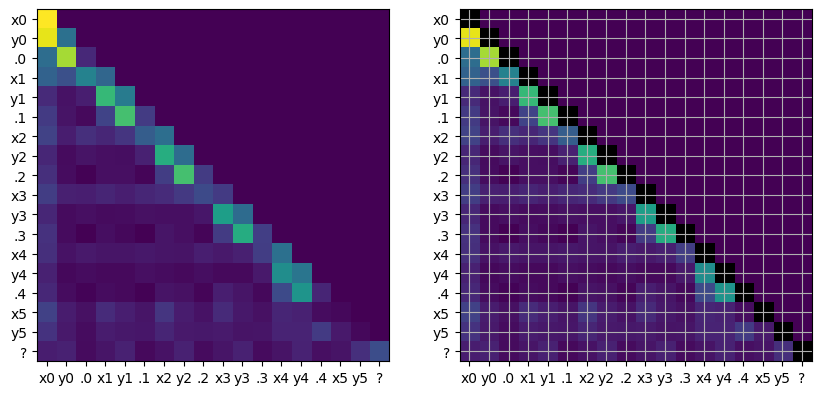

In [771]:
labels = []
for i in range(6):
    labels.append(f"x{i}")
    labels.append(f"y{i}")
    
    if i == 5:
        labels.append("?")
    else:
       labels.append(f".{i}")
       
layer = 2
head = 0
cmap = plt.cm.viridis
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
im = attn_means[:, layer, head, :, :].mean(axis=0)
ax[0].imshow(im, cmap=cmap, vmin=0, vmax=0.75)
for i in range(2):
    ax[i].set_xticks(np.arange(18), labels)
    ax[i].set_yticks(np.arange(18), labels)

for i in range(18):
    im[i, i] = np.nan
ax[1].imshow(im, cmap=cmap, vmin=0, vmax=0.75)
ax[1].grid(True)


plt.show()


In [773]:
def apply_triu_mask(im, k = 1):
    mask = np.ones_like(im)
    triu_mask = np.triu_indices_from(mask, k=k)
    im[triu_mask] = np.nan
    return im


In [774]:
g = data._generate_graph()
question_batch, answer_batch = generate_question_batch_single_graph(g)
logits, attn = complexModel.forward_with_weights(question_batch)
attn = concat_attn(attn)

ticks = [data.inverse_map[q] for q in question_batch[0].detach().numpy()]
print("".join(ticks))

ea.ed.dc.eb.ab.ab?


In [782]:
samp = 0
def get_same_token_scores(question_batch, attn_batch):
    n_samp = attn_batch.shape[0]
    same_token_scores = np.empty((n_samp, 2, 3))
    for samp in range(n_samp):
        for layer in range(3):
            q_np = question_batch[samp].detach().numpy()
            attn_np = attn_batch[samp, layer, 0, :, :].detach().numpy()
            same_tokens_idx = apply_triu_mask(np.array(q_np.reshape(-1, 1) == q_np.reshape(1, -1), dtype = float), k = 0)

            grammar_idx = (q_np == 10)
            grammar_mat = grammar_idx.reshape(-1, 1) | grammar_idx.reshape(1, -1)
            grammar_mat = apply_triu_mask(np.array(grammar_mat, dtype=float), k=0)

            question_idx = np.zeros(18, dtype=bool)
            question_idx[-3:] = True
            question_idx = question_idx.reshape(-1, 1) | question_idx.reshape(1, -1)
            question_idx = apply_triu_mask(np.array(question_idx, dtype=float), k=0)


            same_token_scores_samp = attn_np[(same_tokens_idx == 1) & (grammar_mat == 0) & (question_idx == 0)]
            other_token_scores_samp = attn_np[(same_tokens_idx == 0) & (grammar_mat == 0) & (question_idx == 0)]

            same_token_scores[samp, :, layer] = np.array([same_token_scores_samp.mean(), other_token_scores_samp.mean()])
    return same_token_scores

question_batch, answer_batch = data.generate_batch(5000, type='test')
logits, attn_batch = complexModel.forward_with_weights(question_batch)
attn_batch = concat_attn(attn_batch)

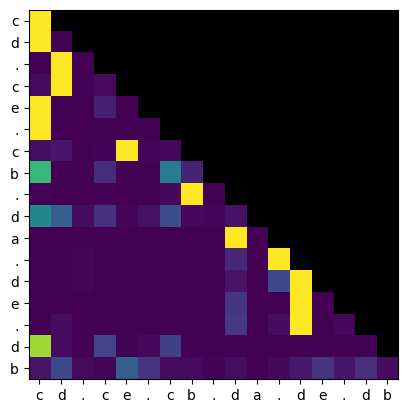

In [780]:
layer = 2
samp = 1
ticks = [data.inverse_map[q] for q in question_batch[samp].detach().numpy()]
im = apply_triu_mask(attn_batch[samp, layer, 0, :, :].detach().numpy())
plt.imshow(im, cmap=cmap, vmax = 0.75)
plt.xticks(range(len(ticks)), ticks)
plt.yticks(range(len(ticks)), ticks)
plt.xlim([-0.5, 16.5])
plt.ylim([-0.5, 16.5])
plt.gca().invert_yaxis()
plt.show()

In [783]:
same_token_scores = get_same_token_scores(question_batch, attn_batch)

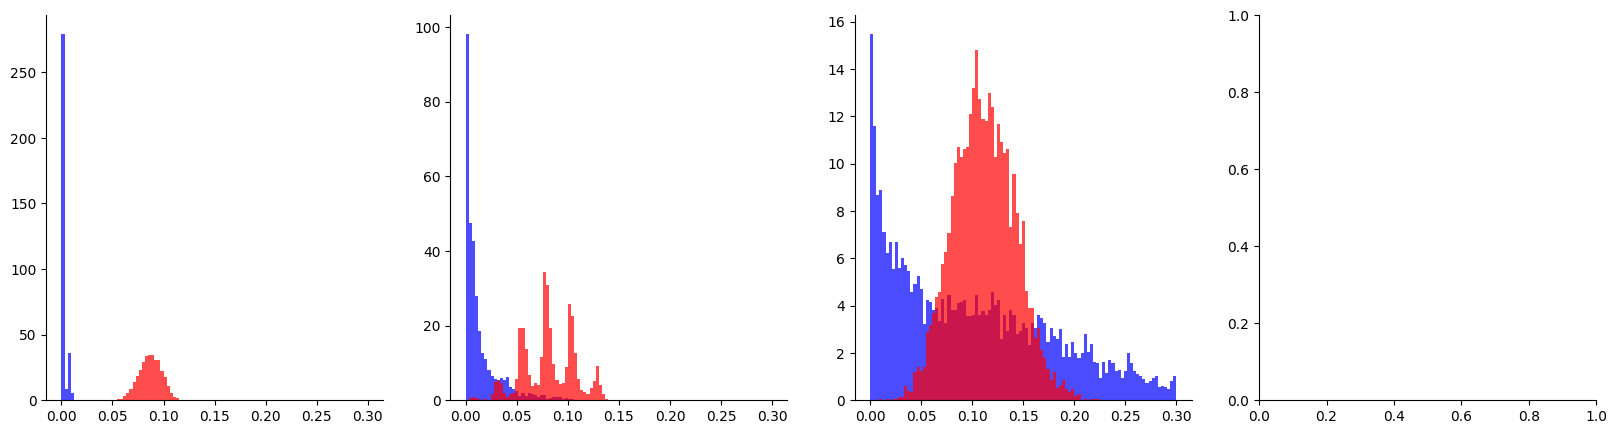

In [785]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
bins = np.linspace(0, 0.3, 100)
for layer in range(3):
    ax[layer].set_title("layer " + str(layer))
    ax[layer].hist(same_token_scores[:, 0, layer], bins, color="b", alpha=0.7, density=True)
    ax[layer].hist(same_token_scores[:, 1, layer], bins, color="r", alpha=0.7, density=True)
sns.despine()